# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import unicodedata
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from afinn import Afinn
import seaborn as sns
from gensim.parsing.preprocessing import remove_stopwords,STOPWORDS

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [34]:
df=pd.read_csv('BA_reviews.csv',index_col=0)
df.head()

,reviews
0,✅ Trip Verified | Care and support shocking. ...
1,✅ Trip Verified | Flying A380 business class ...
2,✅ Trip Verified | British Airways absolutely ...
3,✅ Trip Verified | My recent experience with B...
4,✅ Trip Verified | This is to express our disp...


In [35]:
df.reviews=df.reviews.apply(lambda x:x[x.find('|')+2:].strip())
df.head()

,reviews
0,Care and support shocking. Written by a previo...
1,Flying A380 business class should be a pleasur...
2,British Airways absolutely does not care. My r...
3,My recent experience with British Airways was ...
4,This is to express our displeasure and concern...


In [36]:
def remove_html(t):
    soup=BeautifulSoup(t,'html.parser')
    return soup.get_text()
def remove_accented(t):
    return unicodedata.normalize('NFKD',t).encode('ascii','ignore').decode('utf-8','ignore')
def remove_special_char(text,dig=False):
    p=r'[^a-zA-z0-9\s]' if not dig else r'[^a-zA-z\s]'
    return re.sub(p,'',text)
def normalize(doc):
    doc = remove_html(doc)
    doc = remove_accented(doc)
    doc = doc.lower()
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    special_char_pattern = re.compile(r'([{.(-)!}])')
    doc = special_char_pattern.sub(" \\1 ", doc)
    doc = remove_special_char(doc,dig=True) 
    doc = re.sub(' +', ' ', doc) 
    return doc

df['reviews_norm']=df.reviews.apply(normalize)
df.head()

,reviews,reviews_norm
0,Care and support shocking. Written by a previo...,care and support shocking written by a previou...
1,Flying A380 business class should be a pleasur...,flying a business class should be a pleasure b...
2,British Airways absolutely does not care. My r...,british airways absolutely does not care my re...
3,My recent experience with British Airways was ...,my recent experience with british airways was ...
4,This is to express our displeasure and concern...,this is to express our displeasure and concern...


In [37]:
df['sentiment_score']=df.reviews_norm.apply(lambda x:Afinn().score(x))
df['sentiment_type']=df.sentiment_score.apply(lambda x:'positive' if x>0 else 'negative' if x<0 else
                                              'neutral')
df.head()

,reviews,reviews_norm,sentiment_score,sentiment_type
0,Care and support shocking. Written by a previo...,care and support shocking written by a previou...,1.0,positive
1,Flying A380 business class should be a pleasur...,flying a business class should be a pleasure b...,-1.0,negative
2,British Airways absolutely does not care. My r...,british airways absolutely does not care my re...,-13.0,negative
3,My recent experience with British Airways was ...,my recent experience with british airways was ...,-20.0,negative
4,This is to express our displeasure and concern...,this is to express our displeasure and concern...,-18.0,negative


In [38]:
df.sentiment_score.describe()

count    1000.000000
mean        1.395000
std        11.267828
min       -49.000000
25%        -6.000000
50%         0.000000
75%         8.000000
max        68.000000
Name: sentiment_score, dtype: float64

In [39]:
df.sentiment_type.value_counts()

negative    494
positive    455
neutral      51
Name: sentiment_type, dtype: int64

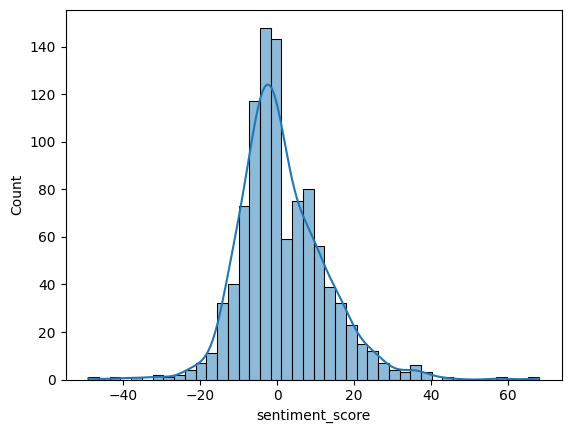

In [40]:
sns.histplot(x=df.sentiment_score,kde=True)
plt.show()

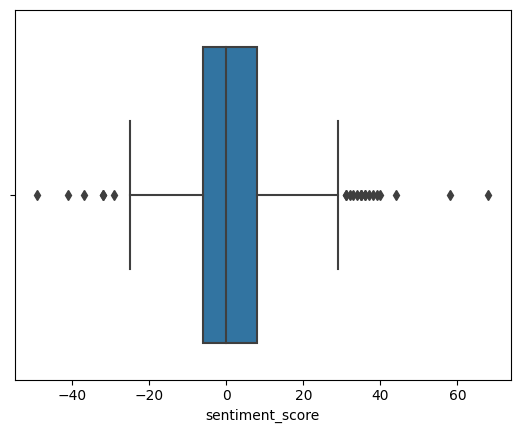

In [51]:
sns.boxplot(x=df.sentiment_score)
plt.show()

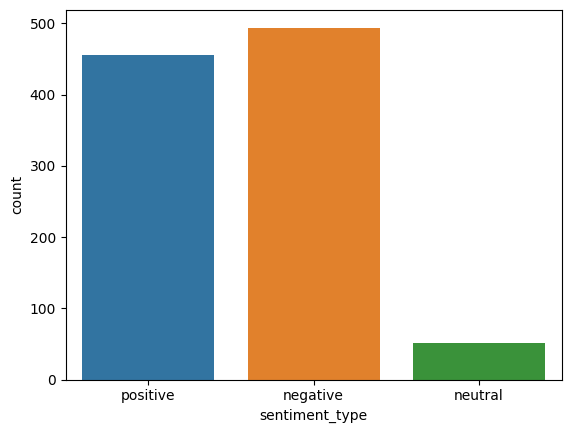

In [41]:
sns.countplot(x=df.sentiment_type)
plt.show()

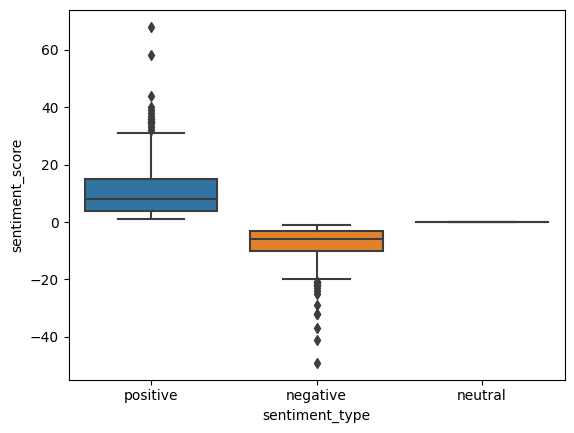

In [42]:
sns.boxplot(x=df.sentiment_type,y=df.sentiment_score)
plt.show()

In [43]:
df.reviews[df.sentiment_score==min(df.sentiment_score)].iloc[0]

"Hong Kong to Copenhagen via London. The whole experience is a nightmare to me and my wife. My wife lost her luggage ever since the first day of our journey on 1st August because our two pieces of luggage were left in Heathrow Airport by BA staff when we took the transit flight from the UK to Copenhagen. We went to Menzies in CPH and they filed a repor. We stated in the missing report that if the luggage was found, they should be sent to our air b&b house in Marstal in CPH on or before 3rd August or deliver to the hotel we stayed in CPH if they were found on 4th August. On 2nd August, we found that the updated status of our missing luggage in the BA website showed that one of our luggage was found while another one had a possible match. Therefore, we kept phoning and emailing Menzies staff to urge them to send the luggage to our house but they failed to do so. And the website status showed that we chose to pick up the luggage in the airport, which was not our preference but we failed t

In [44]:
df.reviews[df.sentiment_score==max(df.sentiment_score)].iloc[0]

'I was supposed to fly with Aeroflot on the 23rd of December to Moscow. But because Russia has closed its borders, like the majority of other countries, the flight was canceled, and I couldn’t get home. I’ve also tried to fly through Antalya, but the same situation occurred. On my third try, I came to Heathrow and tried to fly away to Cairo. I was declined by another company. Then I went to British Airways. Starting from testing (because Egypt requires tests), as stressful as the whole situation was, the employees were outstanding! (I’m not sure is it connected to BA, but still, I want to mention this). The crew was very helpful and extremely understanding, very professional and urgent to help, they have been a great help and I am very gracious for this. I want to separately point out one employee - Shanell (if I am not mistaken, who works at Collision testing center in Heathrow Terminal 5). She is a savior and most importantly a human, which is very rare nowadays! Carrying on, I went 

In [46]:
df.reviews_norm=df.reviews_norm.apply(lambda x:remove_stopwords(x))
df.head()

,reviews,reviews_norm,sentiment_score,sentiment_type
0,Care and support shocking. Written by a previo...,care support shocking written previously loyal...,1.0,positive
1,Flying A380 business class should be a pleasur...,flying business class pleasure ba disaster wor...,-1.0,negative
2,British Airways absolutely does not care. My r...,british airways absolutely care reserved seat ...,-13.0,negative
3,My recent experience with British Airways was ...,recent experience british airways horrendous u...,-20.0,negative
4,This is to express our displeasure and concern...,express displeasure concerns flight italy trip...,-18.0,negative


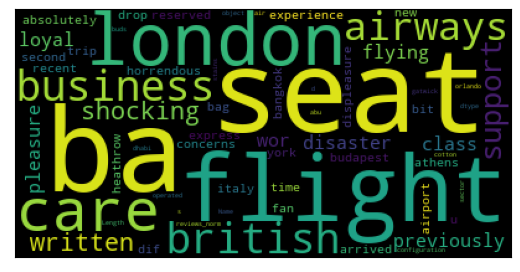

In [47]:
wc=WordCloud().generate(str(df.reviews_norm))
plt.imshow(wc)
plt.xticks([])
plt.yticks([])
plt.show()

In [62]:
df.reviews[df.reviews_norm.str.count('seat').idxmax()]

'The connecting flight to Johannesburg was on an older 737-400 with proper business class seats and lots of legroom. Pre-take off drinks offered and a decent meal for a short flight. Everything went smoothly and service was good. Boarding for the main flight was on time and proceeded smoothly, we were seated on the upper deck in the forward cabin. Much has been said about the BA ying-yang seat configuration. The seats are narrow, and there is a lack of privacy for the aisle seat, with probably the main complaint being lack of storage for personal items around the seat. However the seat is very comfortable in any position, and the White Company bedding is excellent. We had an aisle / centre seats at the rear of the cabin, which worked well as a couple with the privacy screen left down. The centre seat does have a shelf for personal belongings, and access from this seat does not require stepping over another passenger. The service on this flight was superb, from the welcome on boarding a

In [63]:
df.reviews[df.reviews_norm.str.count('flight').idxmax()]

'My wife and I booked a flight in April 2022 that included a return trip from Edinburgh thru London to Washington. When we checked in at Edinburgh Airport 3 hours ahead of time we were informed there were no more seats available on our scheduled flight. We asked how this was possible and were simply told that others had checked in on-line (which we hadn’t done).  We were instructed to come back in 2 hrs and 15 mins, still with our luggage unchecked and not yet going thru security, to see if we could get on the flight via standby. We waited and then finally at 1:15 PM, 45 mins before our scheduled 2:00 PM flight, we were told we could be on the flight and were given boarding passes for the flight to London but no boarding passes for the connecting flight (1:55 mins after arrival time). Our luggage was not checked thru to Washington but only to London. We were told we’d get thru security on time to make the flight and it was suggested that staff would assist us. When we got to Security C

In [64]:
df.reviews[df.reviews_norm.str.count('london').idxmax()]

"This is to express our displeasure and concerns regarding our flight to Italy. Our trip was effectively ruined by the failure of our luggage to arrive with us, coupled with the length of time it took for it to eventually reach us (9 and 12 days)! Our departure dates: June 19, 2023 - Flight BA 294, Chicago to London. June 20 rebooked by BA on BA 546, London to Rome. All flights were late. On arrival in Rome, my wife was forced to walk to the check-in desk because our reservation for wheelchair assist from the plane was never transferred by BA. She was told by the cabin crew that there was no reservation for her transport. Also, our checked baggage (2) failed to make the BA rebooked flight from London to Rome. BA took 9 days to deliver my bag and 12 days to deliver my wife's. I called BA Baggage Claim Services daily. I was frequently cut off after waiting on hold for over an hour. We had Apple Air tags in both bags, and sent pictures showing their exact location to BA Baggage Claim seve